In [101]:
import pandas as pd
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import numpy as np

In [102]:
df = pd.read_excel("premiums_young.xlsx")
print(df.shape)
df.head()

(20096, 13)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [103]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [104]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [105]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [106]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [107]:
df.duplicated().sum()

0

In [108]:
df.drop_duplicates(inplace=True) ##in case datasets changes and have duplicates value it still be handled
df.duplicated().sum()

0

In [109]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [110]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [111]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [112]:
numeric_col = df.select_dtypes(['float64', 'int64']).columns
numeric_col

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

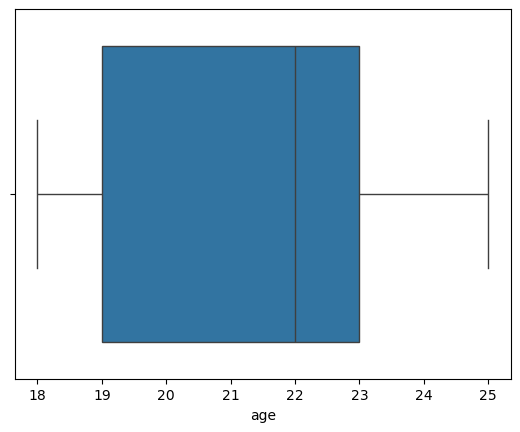

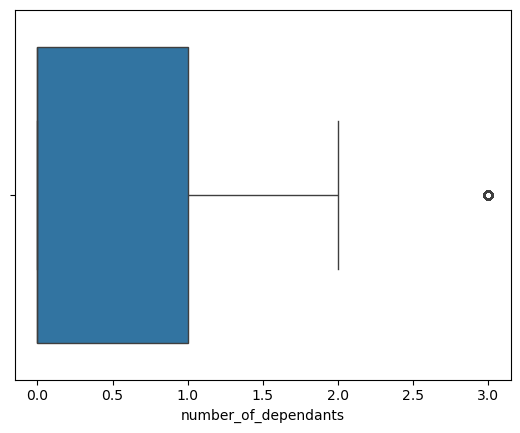

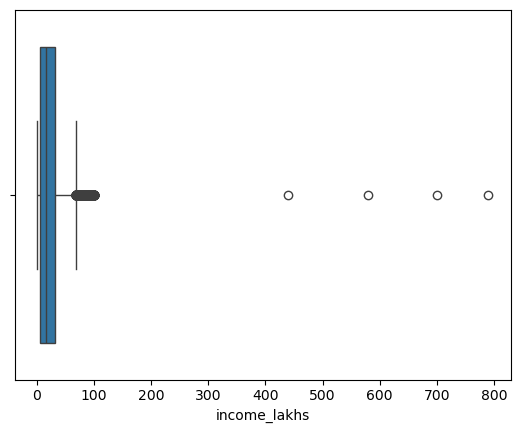

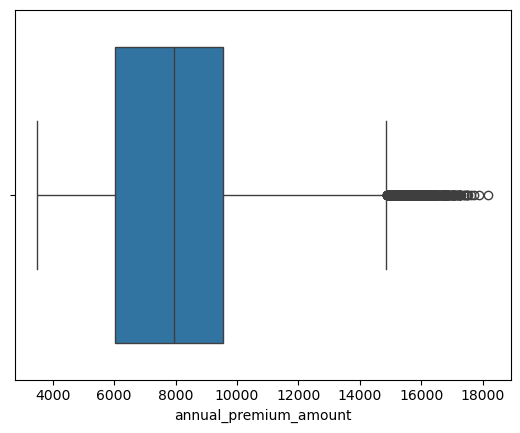

In [113]:
for col in numeric_col:
    sbn.boxplot(x=df[col])
    plt.show()

In [114]:
df[df['age']>100]['age'].unique()

array([], dtype=int64)

In [115]:
df1 = df[df['age']<100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [116]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return lower, upper

In [117]:
get_iqr_bounds(df1.income_lakhs) ## we can use this upper bond here but can use common sense as well for example just use quantile

(-31.5, 68.5)

In [118]:
income_thre = df1['income_lakhs'].quantile(0.999)
income_thre

100.0

In [119]:
df1[df1['income_lakhs']> income_thre].shape

(4, 13)

In [120]:
df2 = df1[df1['income_lakhs']<income_thre].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20054.000000,20054.000000,20054.000000,20054.000000
mean,21.494016,0.722449,22.266530,8136.902413
std,2.294382,0.937033,21.526939,2748.132286
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6019.000000
50%,21.000000,0.000000,16.000000,7936.500000
75%,23.000000,1.000000,31.000000,9552.750000
max,25.000000,3.000000,99.000000,18186.000000


In [121]:
df2.shape

(20054, 13)

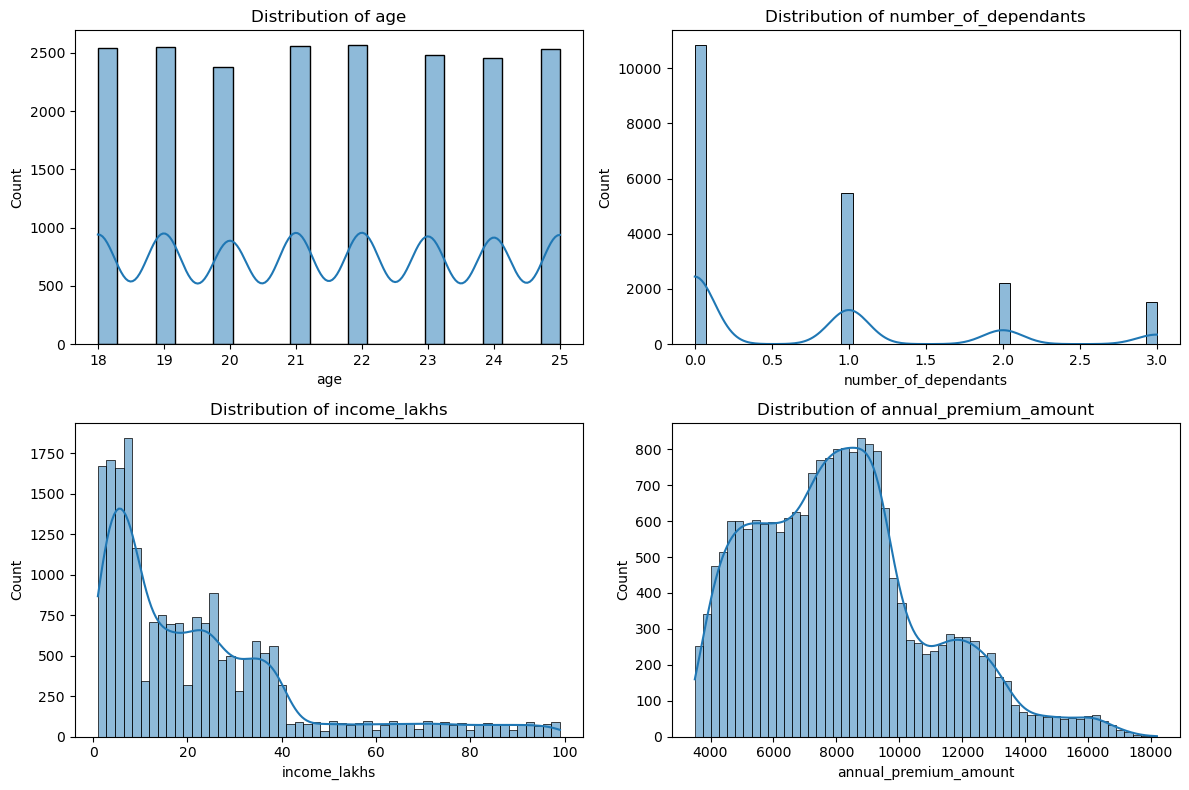

In [122]:
# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten the axes array for easy looping
axes = axes.flatten()

for i, col in enumerate(numeric_col):
    sbn.histplot(x=df2[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

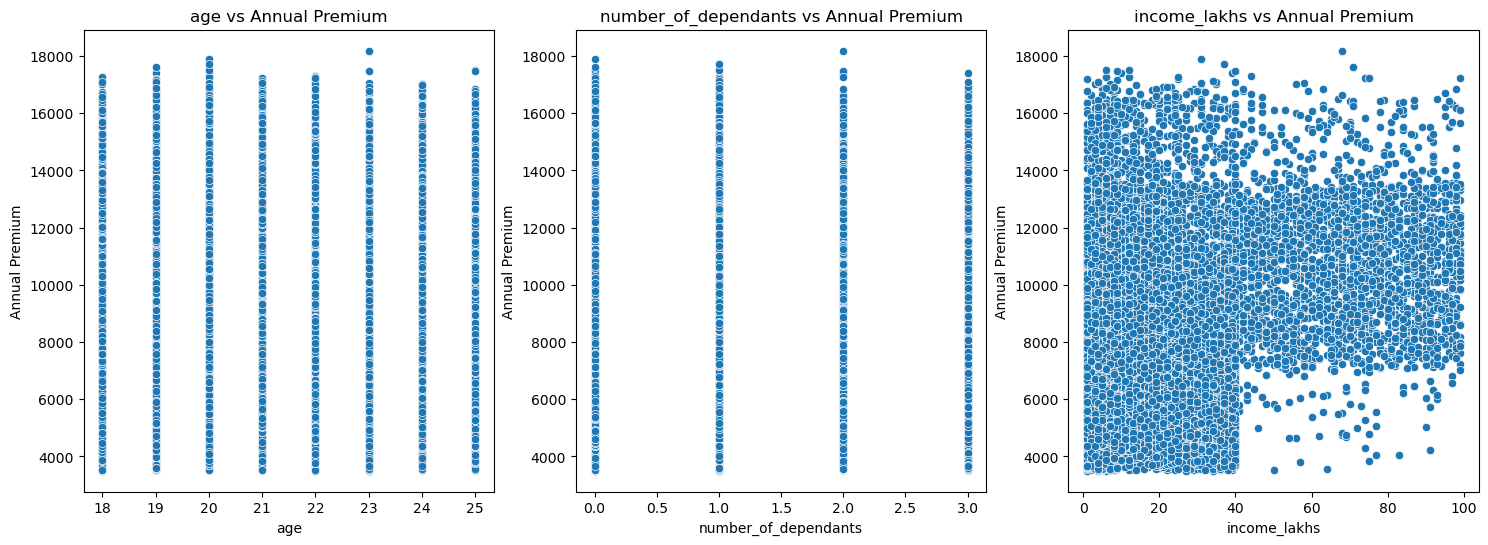

In [123]:
numeric_features = ['age', 'number_of_dependants', 'income_lakhs']
fig, axes = plt.subplots(1, len(numeric_features), figsize=(18,6))

for ax, col in zip(axes, numeric_features):
    sbn.scatterplot(x=df2[col], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{col} vs Annual Premium')
    ax.set_xlabel(col)
    ax.set_ylabel("Annual Premium")

plt.show()

In [124]:
cat_col = df.select_dtypes(['object', 'string']).columns
cat_col

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [125]:
for col in cat_col:
    print(col, df[col].unique())

gender ['Male' 'Female']
region ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status ['Unmarried' 'Married']
bmi_category ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status ['Self-Employed' 'Freelancer' 'Salaried']
income_level ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan ['Silver' 'Bronze' 'Gold']


In [126]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)
df2['smoking_status'].unique()

/var/folders/qf/y5py1tn96jb51xf2nngtndw80000gn/T/ipykernel_6606/321161999.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [127]:
pct_gender = df2['gender'].value_counts(normalize=True)
pct_gender

gender
Male      0.550364
Female    0.449636
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

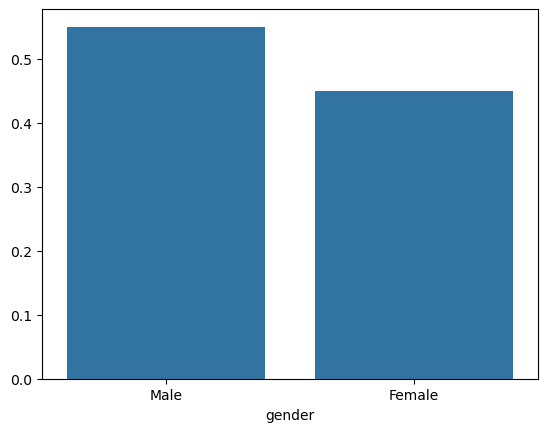

In [128]:
sbn.barplot(x=pct_gender.index, y=pct_gender.values)

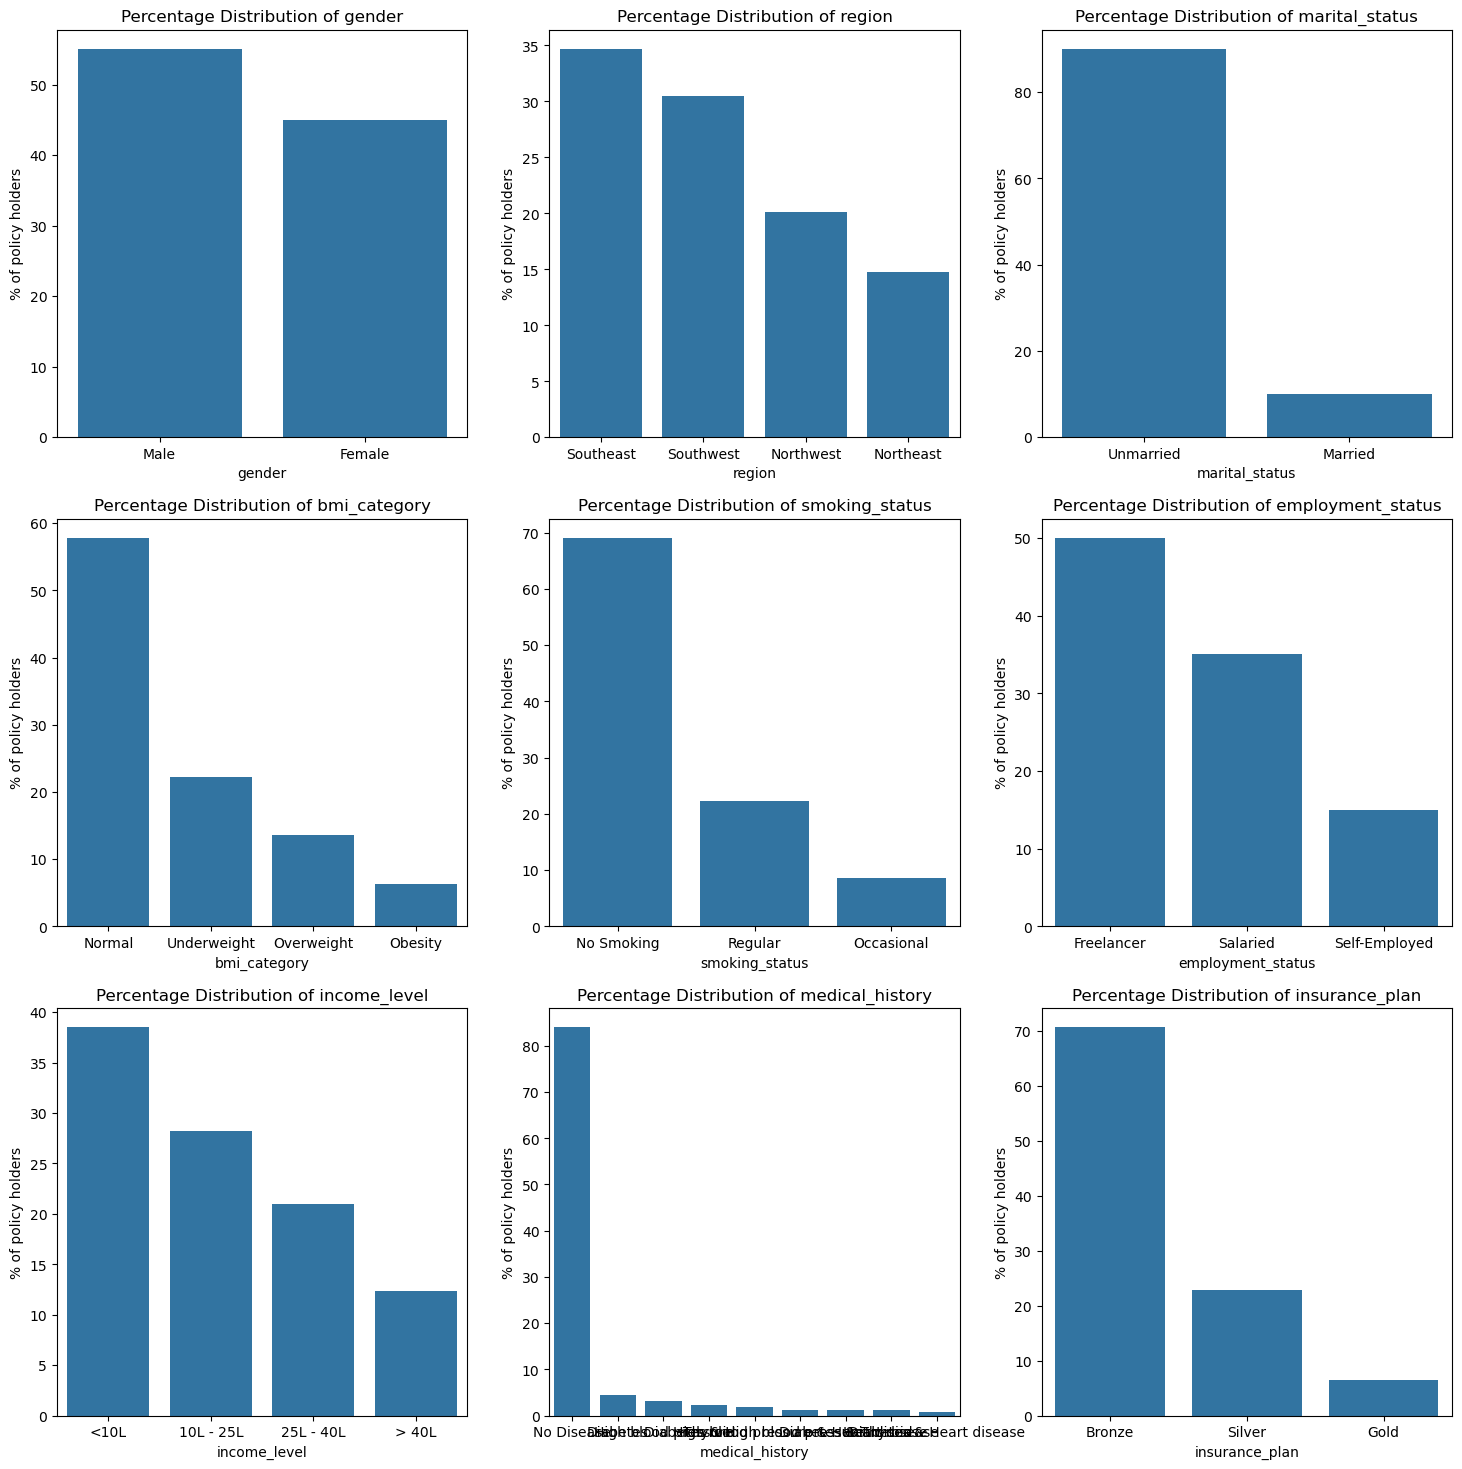

In [129]:
fig, axes = plt.subplots(3, 3, figsize=(18,18))
axes = axes.flatten()

for ax, col in zip(axes, cat_col):
    cat_count = df2[col].value_counts(normalize=True) * 100
    sbn.barplot(x=cat_count.index, y=cat_count.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel("% of policy holders")

plt.show()

In [130]:
cross_tab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
cross_tab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,362,1995


<Axes: xlabel='income_level'>

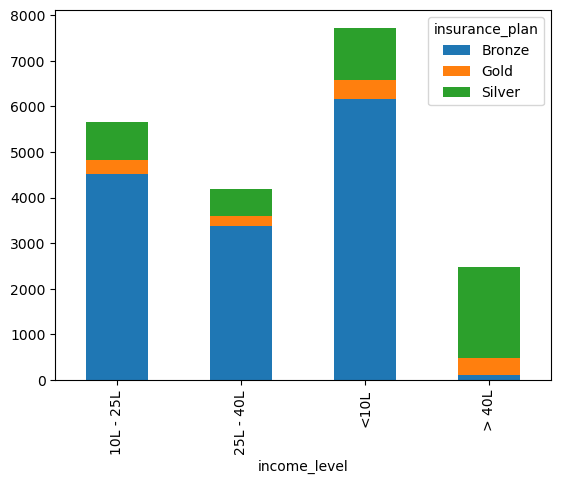

In [131]:
cross_tab.plot(kind="bar", stacked=True)

<Axes: xlabel='insurance_plan', ylabel='income_level'>

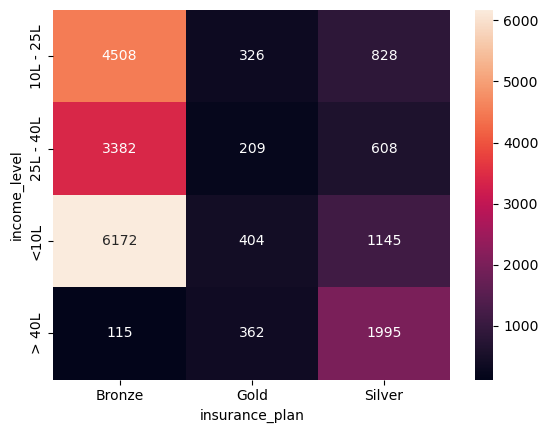

In [132]:
sbn.heatmap(cross_tab, annot=True, fmt='d')

In [133]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

In [134]:
df2[['disease1','disease2']]=df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())

In [135]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,None
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,None


In [136]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1','disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

/var/folders/qf/y5py1tn96jb51xf2nngtndw80000gn/T/ipykernel_6606/3623383084.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
/var/folders/qf/y5py1tn96jb51xf2nngtndw80000gn/T/ipykernel_6606/3623383084.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


In [137]:
df2.sample(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
9248,22,Male,Northwest,Unmarried,1,Underweight,No Smoking,Freelancer,<10L,5,Diabetes,Gold,13968,diabetes,none,6,0.428571
19350,22,Male,Southeast,Unmarried,1,Normal,Regular,Salaried,<10L,7,No Disease,Bronze,8997,no disease,none,0,0.000000
1422,21,Female,Southeast,Unmarried,0,Overweight,No Smoking,Salaried,<10L,5,No Disease,Bronze,7126,no disease,none,0,0.000000
5310,20,Male,Northeast,Married,3,Normal,Regular,Salaried,10L - 25L,14,Heart disease,Bronze,7149,heart disease,none,8,0.571429
16257,22,Female,Northwest,Unmarried,1,Underweight,No Smoking,Self-Employed,<10L,6,No Disease,Bronze,7402,no disease,none,0,0.000000
8301,18,Male,Northeast,Unmarried,0,Normal,Regular,Freelancer,<10L,9,Diabetes & High blood pressure,Bronze,9221,diabetes,high blood pressure,12,0.857143
9902,20,Male,Southwest,Unmarried,2,Overweight,Regular,Freelancer,25L - 40L,33,No Disease,Bronze,7462,no disease,none,0,0.000000
13250,18,Male,Northwest,Unmarried,1,Overweight,Regular,Self-Employed,10L - 25L,11,No Disease,Silver,10643,no disease,none,0,0.000000
2506,22,Female,Northwest,Unmarried,1,Overweight,No Smoking,Salaried,<10L,6,No Disease,Bronze,5069,no disease,none,0,0.000000
6460,23,Female,Northwest,Unmarried,2,Overweight,No Smoking,Salaried,<10L,7,High blood pressure,Bronze,6685,high blood pressure,none,6,0.428571


In [138]:
df2['insurance_plan'] = df2['insurance_plan'].map({
    'Bronze':1,
    'Silver':2,
    'Gold':3
})
df2['insurance_plan'].unique()

array([2, 1, 3])

In [139]:
df2['income_level'].unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [140]:
df2['income_level'] = df2['income_level'].map({
    '<10L':1,
    '10L - 25L':2,
    '25L - 40L':3,
    '> 40L':4
})
df2['income_level'].unique()

array([4, 1, 2, 3])

In [141]:
nominal_col = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status','employment_status']
df3 = pd.get_dummies(df2, columns=nominal_col, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [142]:
df4 = df3.drop(['disease1','disease2', 'total_risk_score', 'medical_history'], axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


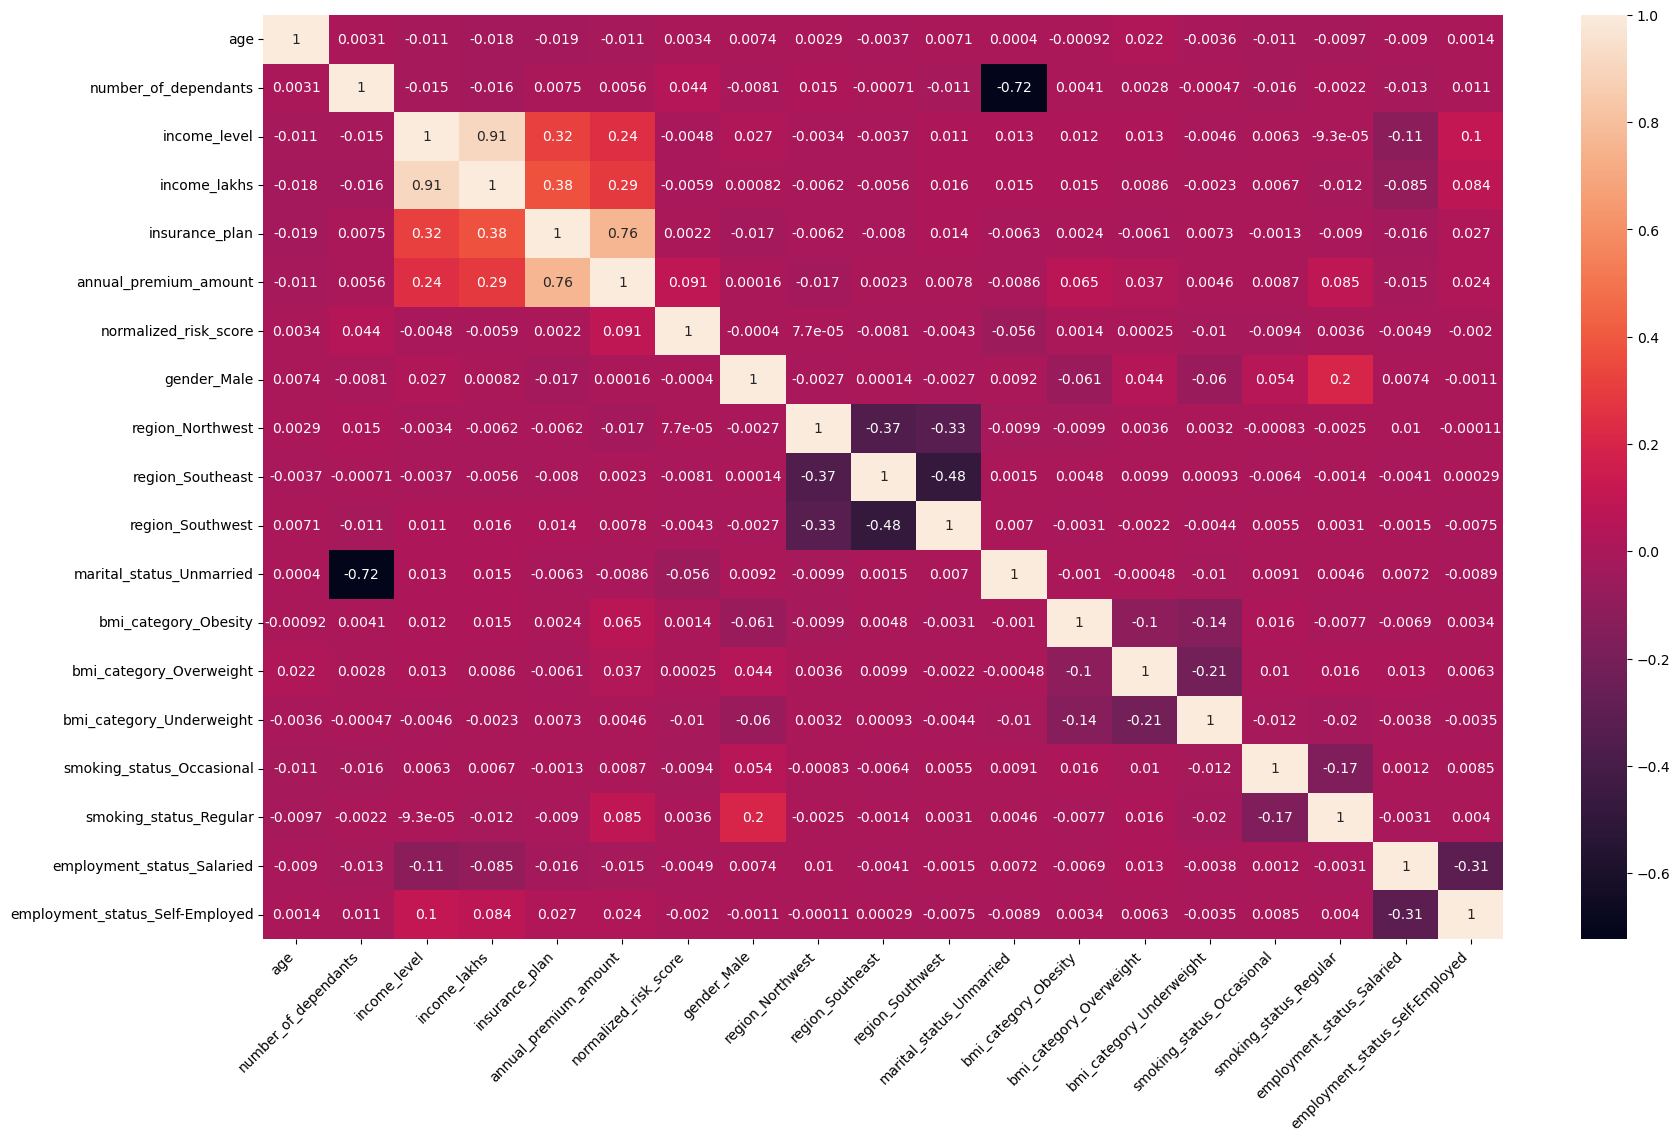

In [143]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sbn.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [144]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


In [145]:
X = df4.drop('annual_premium_amount', axis=1)
y= df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

col_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[col_to_scale] = scaler.fit_transform(X[col_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000
mean,0.499145,0.240816,0.356970,0.217005,0.178967,0.092130,0.550364,0.201306,0.346863,0.304578,0.899920,0.063528,0.136531,0.222300,0.086417,0.223497,0.350155,0.149945
std,0.327769,0.312344,0.346809,0.219663,0.299827,0.230059,0.497469,0.400987,0.475984,0.460240,0.300114,0.243917,0.343360,0.415802,0.280985,0.416599,0.477030,0.357027
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.051020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.428571,0.000000,0.333333,0.153061,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.306122,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [146]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [147]:
calculate_vif(X)

,Column,VIF
0,age,3.142125
1,number_of_dependants,1.860137
2,income_level,12.076228
3,income_lakhs,12.064125
4,insurance_plan,1.586966
5,normalized_risk_score,1.154327
6,gender_Male,2.309901
7,region_Northwest,2.147121
8,region_Southeast,2.968665
9,region_Southwest,2.730084


In [148]:
calculate_vif(X.drop('income_level', axis=1))

,Column,VIF
0,age,3.140709
1,number_of_dependants,1.857617
2,income_lakhs,2.293723
3,insurance_plan,1.581668
4,normalized_risk_score,1.154291
5,gender_Male,2.299671
6,region_Northwest,2.146229
7,region_Southeast,2.967484
8,region_Southwest,2.729448
9,marital_status_Unmarried,7.305480


In [149]:
X_reduced = X.drop('income_level', axis=1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,1.000000,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020408,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.979592,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.142857,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.132653,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)

print(train_score, test_score)

0.6048350981759056 0.5964252843262741


In [151]:
model_lr.coef_, model_lr.intercept_

(array([ 7.26389744e+01, -1.51679170e+01,  6.04888843e+00,  7.00382876e+03,
         1.03703478e+03, -3.14881122e+01, -8.95715718e+01,  9.05237749e+00,
        -5.03905309e+01, -3.11130924e+01,  7.50869774e+02,  4.32893765e+02,
         1.04140913e+02,  3.03204022e+02,  6.60132731e+02, -2.57407237e+01,
         1.56223624e+01]),
 6542.521635489466)

In [152]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
region_Northwest,-89.571572
region_Southwest,-50.390531
gender_Male,-31.488112
marital_status_Unmarried,-31.113092
employment_status_Salaried,-25.740724
number_of_dependants,-15.167917
income_lakhs,6.048888
region_Southeast,9.052377
employment_status_Self-Employed,15.622362
age,72.638974


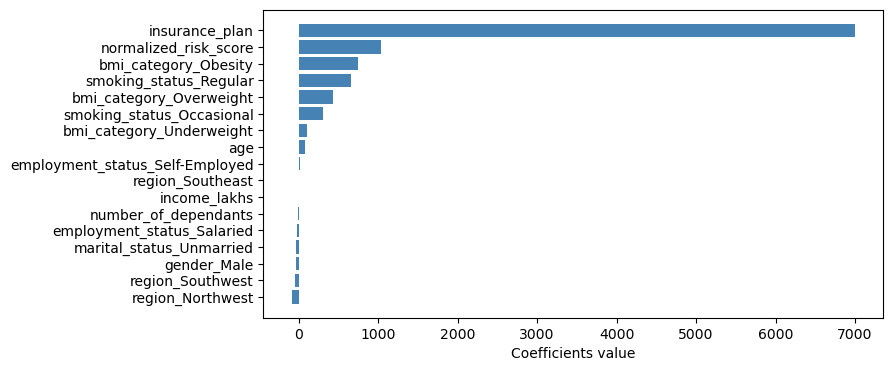

In [153]:
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel("Coefficients value")
plt.show()

In [154]:
from xgboost import XGBRegressor

model_xg = XGBRegressor()
model_xg.fit(X_train, y_train)
train_score = model_xg.score(X_train, y_train)
test_score = model_xg.score(X_test, y_test)
print(train_score, test_score)

0.7274904251098633 0.5569512248039246


In [155]:
y_pred = model_xg.predict(X_test)

print("R2 Score", r2_score(y_pred, y_test))
print("Mean Square Error", mean_squared_error(y_pred, y_test))
print("Root Square Error", np.sqrt(mean_squared_error(y_pred, y_test)))

R2 Score 0.3061014413833618
Mean Square Error 3363838.213281027
Root Square Error 1834.0769376667456


In [156]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.6018239855766296

In [157]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [158]:
best_model = random_search.best_estimator_

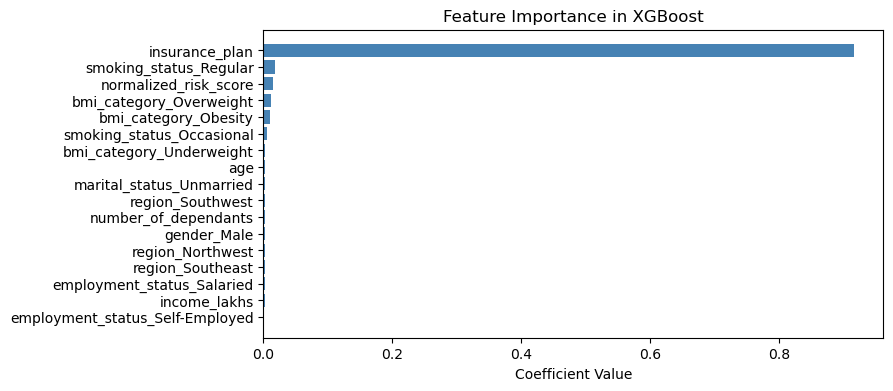

In [159]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [160]:
y_pred = best_model.predict(X_test)
residuals = y_test-y_pred
residual_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residual_pct
})
results_df.head()


,actual,predicted,diff,diff_pct
1710,4096,6981.050781,-2885.050781,-70.435810
11963,4503,6981.050781,-2478.050781,-55.031108
8719,8332,10772.823242,-2440.823242,-29.294566
7208,11578,10084.492188,1493.507812,12.899532
9416,7045,6570.482422,474.517578,6.735523


<Axes: xlabel='diff_pct', ylabel='Count'>

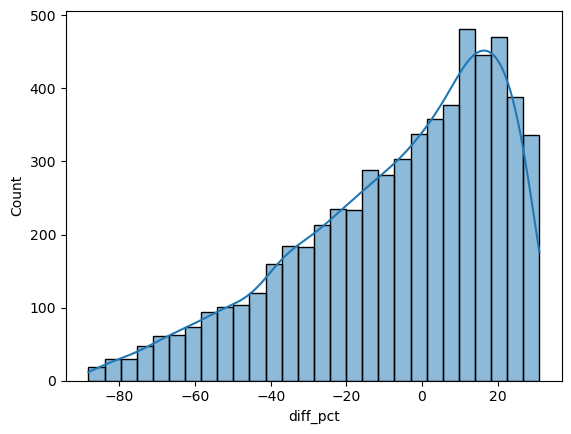

In [161]:
sbn.histplot(results_df['diff_pct'], kde=True)

In [162]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct'])>extreme_error_threshold]
extreme_results_df.shape

(4427, 4)

In [163]:
results_df.shape

(6017, 4)

In [164]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]

In [165]:
results_df[np.abs(results_df['diff_pct'])>50]

,actual,predicted,diff,diff_pct
1710,4096,6981.050781,-2885.050781,-70.435810
11963,4503,6981.050781,-2478.050781,-55.031108
15751,4593,6981.050781,-2388.050781,-51.993268
16,4286,6611.990234,-2325.990234,-54.269488
10357,4668,7464.903809,-2796.903809,-59.916534
...,...,...,...,...
1196,4016,6595.966309,-2579.966309,-64.242189
16023,4577,7386.718750,-2809.718750,-61.387781
20068,4373,6927.104004,-2554.104004,-58.406220
18574,3606,6618.695312,-3012.695312,-83.546736


In [166]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
1710,0.714286,0.0,0.040816,0.0,0.0,0,0,1,0,1,0,1,0,0,0,0,0
11963,1.000000,0.0,0.051020,0.0,0.0,1,0,1,0,1,0,1,0,0,0,0,0
8719,0.428571,0.0,0.061224,0.5,0.0,1,0,0,0,1,0,0,0,0,1,0,0
7208,0.571429,1.0,0.265306,0.5,0.0,0,0,0,1,0,0,0,0,0,0,0,0
15637,0.000000,0.0,0.244898,0.0,0.0,1,0,0,1,1,0,0,0,0,0,1,0


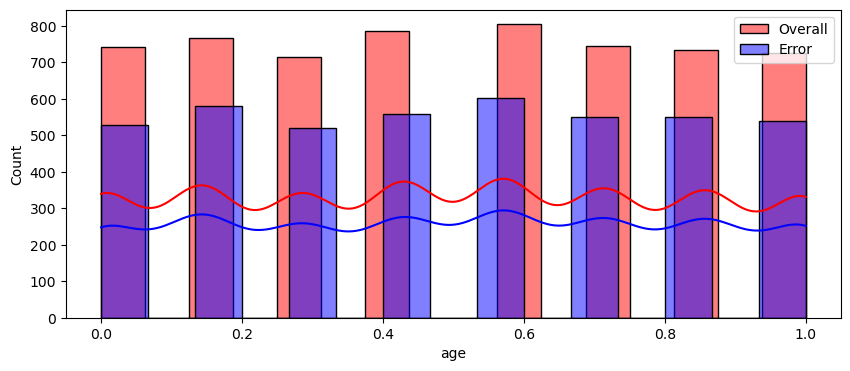

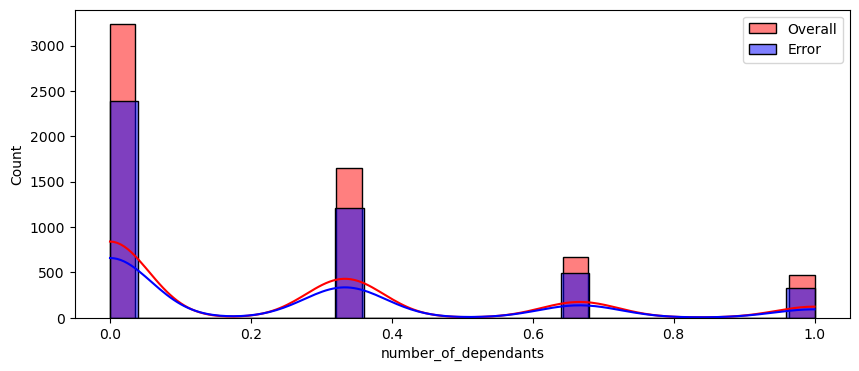

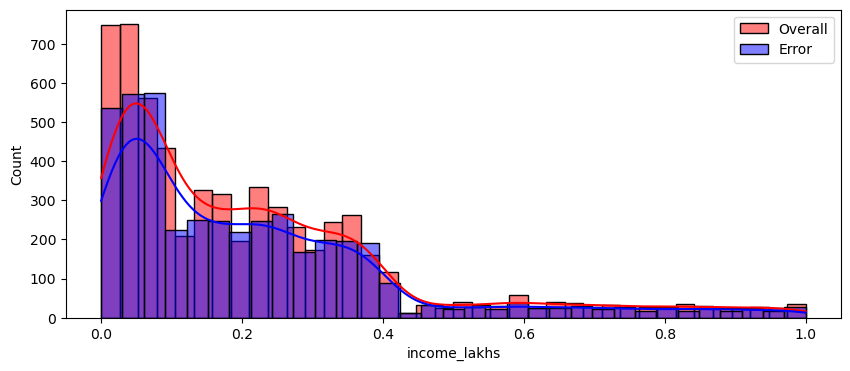

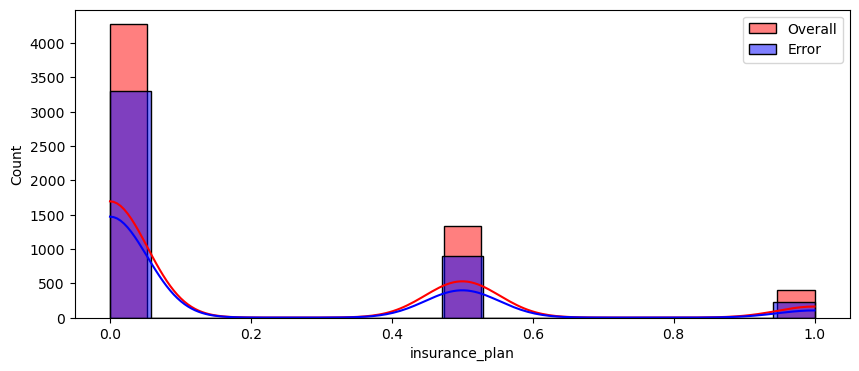

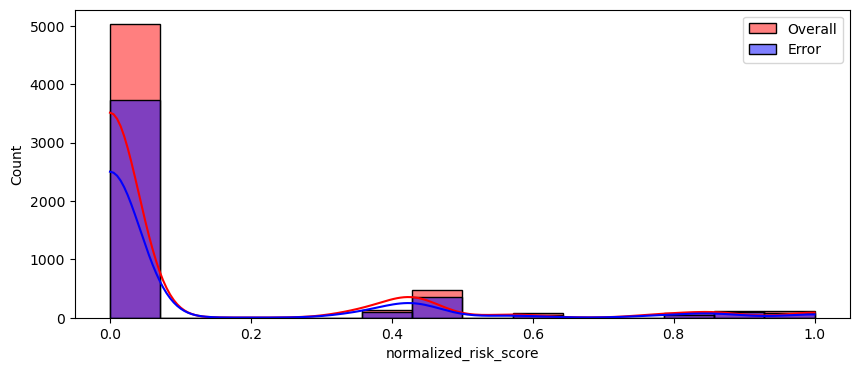

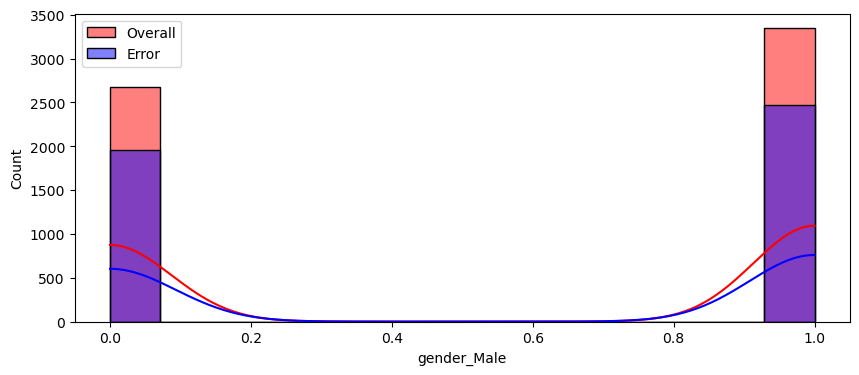

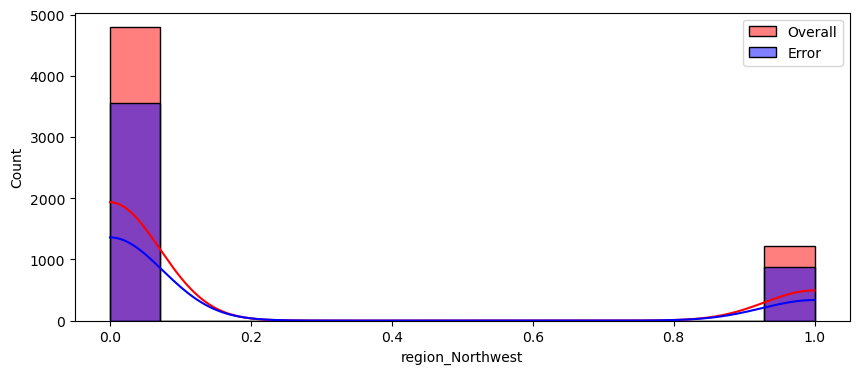

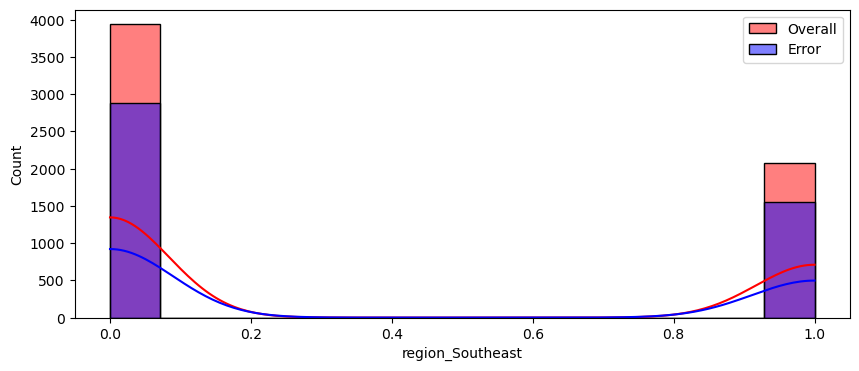

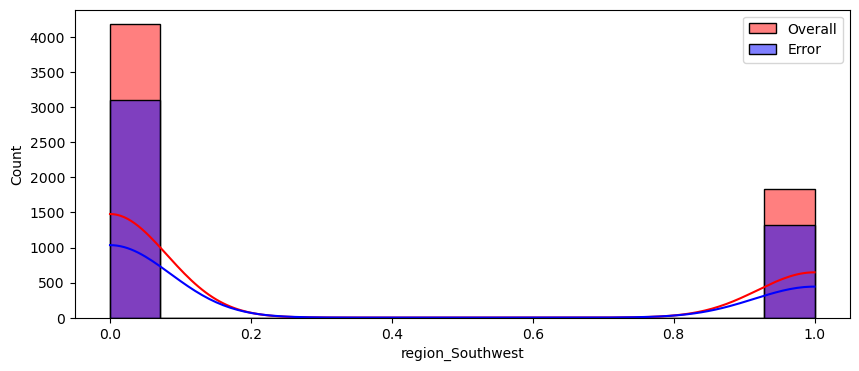

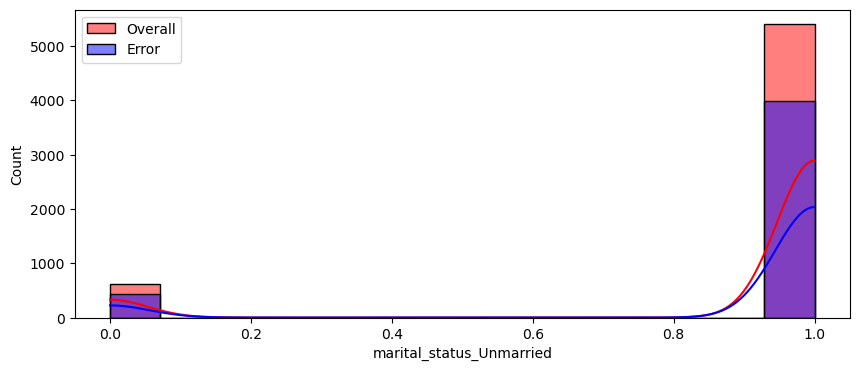

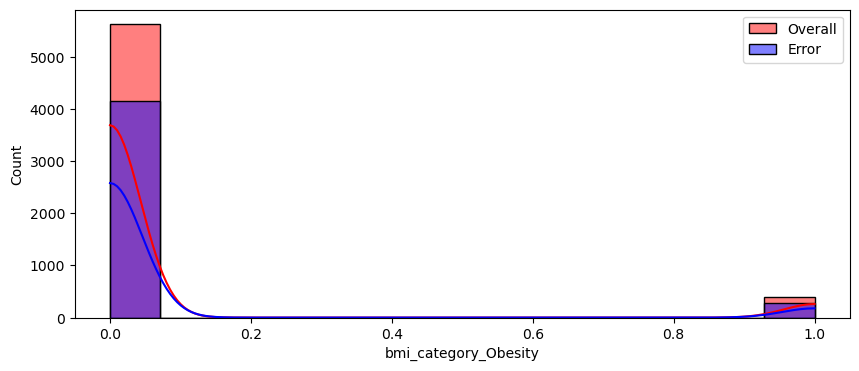

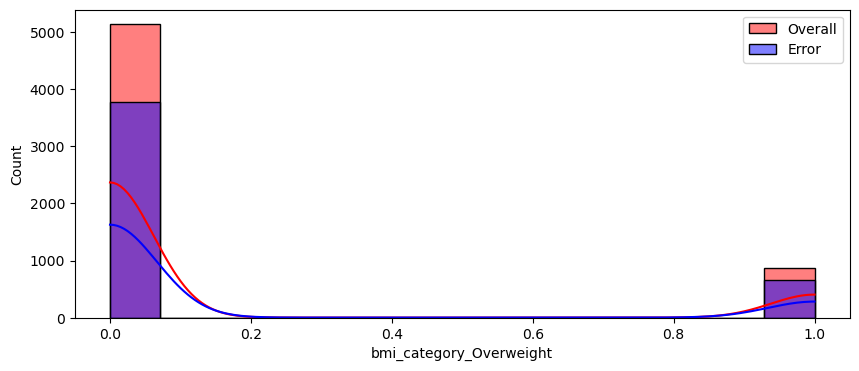

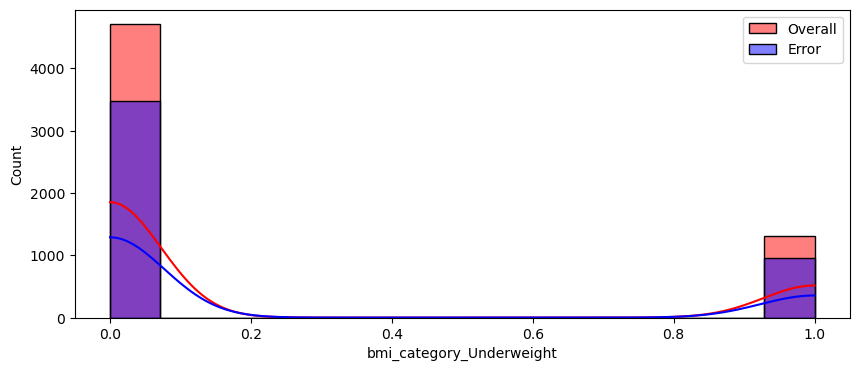

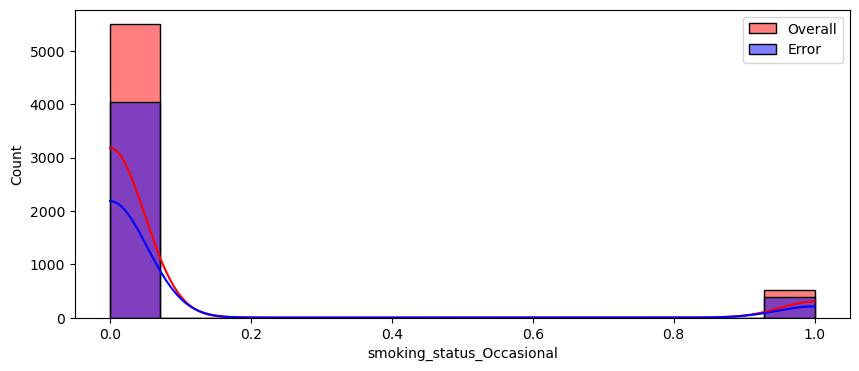

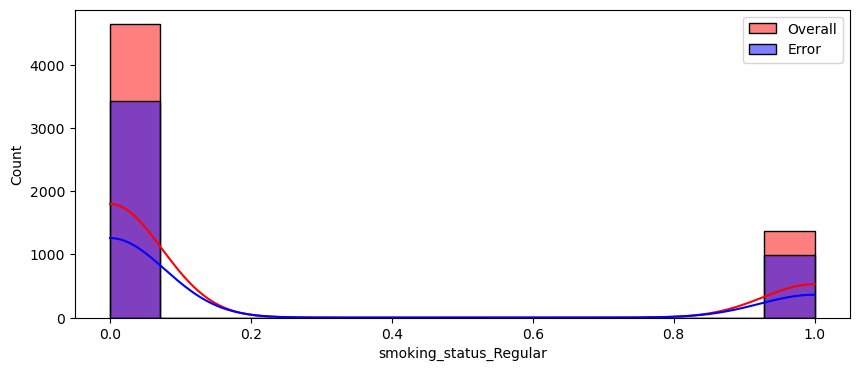

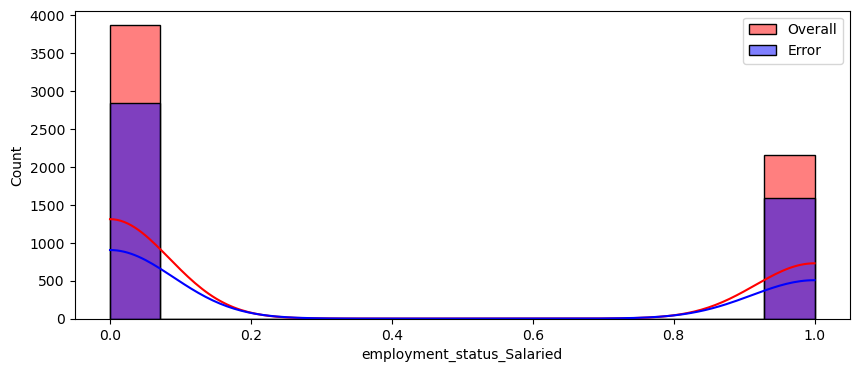

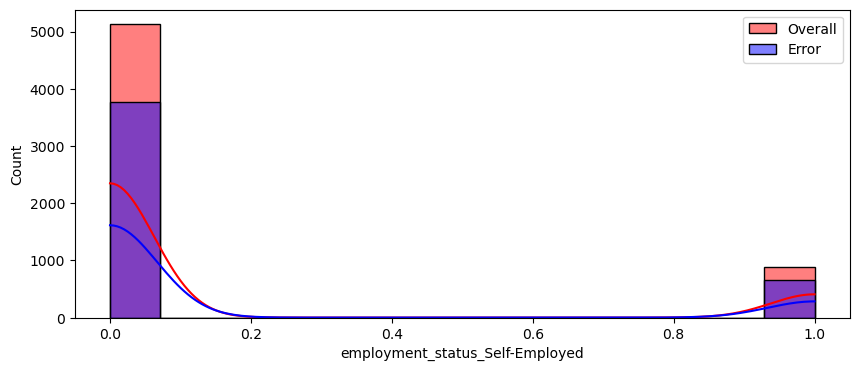

In [167]:
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sbn.histplot(X_test[feature], label='Overall',color='red', kde=True)
    sbn.histplot(extreme_errors_df[feature],label='Error', color='blue', kde=True)
    plt.legend()
    plt.show()

<Axes: xlabel='age', ylabel='Count'>

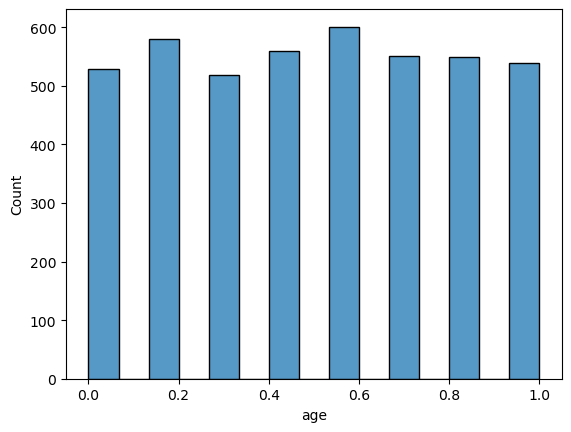

In [168]:
sbn.histplot(extreme_errors_df['age'])

In [169]:
col_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [170]:
extreme_errors_df['income_level'] = -1

In [171]:
df_reversed = pd.DataFrame()
df_reversed[col_to_scale] = scaler.inverse_transform(extreme_errors_df[col_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,0.0,-2.0,5.0,1.0
1,25.0,0.0,-2.0,6.0,1.0
2,21.0,0.0,-2.0,7.0,2.0
3,22.0,3.0,-2.0,27.0,2.0
4,18.0,0.0,-2.0,25.0,1.0


<Axes: xlabel='age', ylabel='Count'>

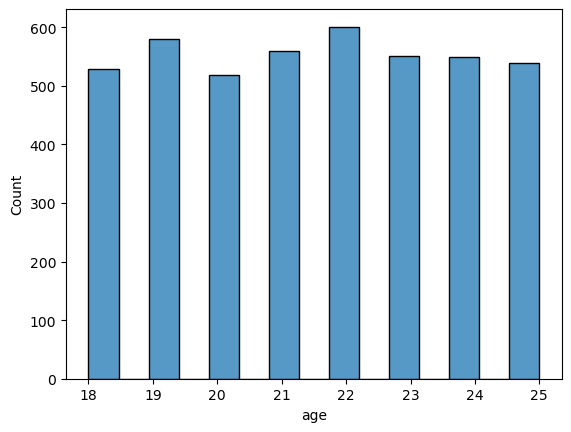

In [172]:
sbn.histplot(df_reversed['age'])

In [173]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4427.000000,4427.000000,4427.0,4427.000000,4427.000000
mean,21.507341,0.720578,-2.0,21.719901,1.307206
std,2.271183,0.934037,0.0,20.485006,0.564462
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,19.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,16.000000,1.000000
75%,23.000000,1.000000,-2.0,31.000000,2.000000
max,25.000000,3.000000,-2.0,99.000000,3.000000


In [174]:
df_reversed['age'].quantile(0.98)

25.0